# Parametric Koopman Learning Tests on Van Der Pol Oscillator

In [1]:

import sys
sys.path.append('..')
import PKoopmanDL as pkdl
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define ODE
ode = pkdl.VanDerPolOscillator()

# Define flow map
dt = 1e-3
t_step = 0.25
flowmap = pkdl.ForwardEuler(t_step, dt)

# Generate data set
n_traj = 1000
traj_len = 10
x_min = -1
x_max = 1
param_min = -1
param_max = 1
dataset = pkdl.ParamODEDataSet(ode, flowmap)
dataset.generate_data(n_traj, traj_len, x_min, x_max, param_min, param_max)

# build dictionary
dim_output = 25
dim_nontrain = 3
dict_layer_size = [100, 100, 100]
nontrain_func = lambda x: torch.cat([torch.ones((x.size(0), 1)).to(x.device), x], dim=1)
dictionary_network = pkdl.FullConnResNet(ode.dim, dim_output - dim_nontrain, dict_layer_size)
dictionary = pkdl.TrainableDictionary(dictionary_network, nontrain_func, ode.dim, dim_output, dim_nontrain)

# build solver
n_epochs = 300
batch_size = 1000
reg = 0.1
reg_final = 0.01
tol = 1e-6
lr = 1e-4
K_layer_size = [256, 256]
koopman_network = pkdl.FullConnNet(ode.param_dim, dim_output**2, K_layer_size)
PK = pkdl.ParamKoopman(dim_output, koopman_network)
solver = pkdl.ParamKoopmanDLSolver(dictionary)
PK = solver.solve(dataset, PK, n_epochs, batch_size, tol, lr, lr)

CUDA is available. GPU is being used.


Training: 100%|██████████| 300/300 [00:48<00:00,  6.15it/s, loss=2.05e-05]


## Plot

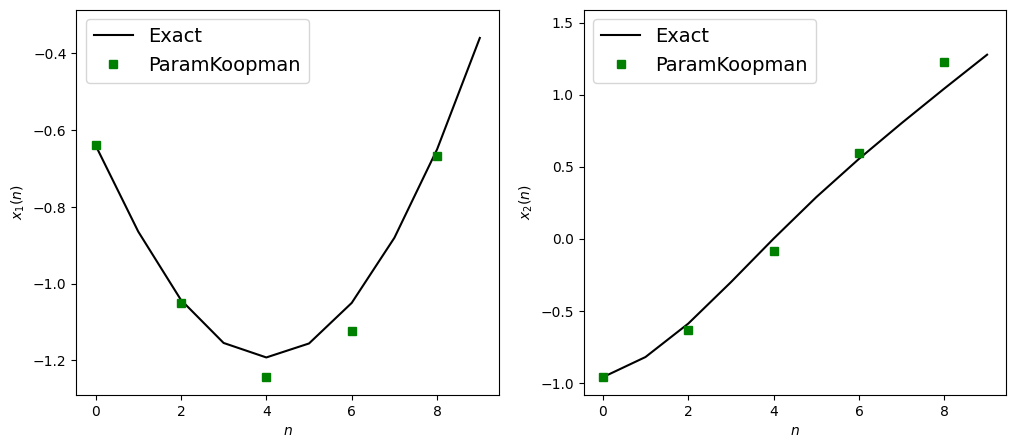

In [3]:
# predict
param = torch.tensor([[0.5]]).detach()
dataset_predict = pkdl.ODEDataSet(ode, flowmap)
dataset_predict.generate_data(1, traj_len, x_min, x_max, param)
x0 = torch.unsqueeze(dataset_predict.data_x[0], dim=0)
p = PK.predict(param, x0, dictionary, dim_nontrain, traj_len).detach()
x_est_traj = p[0, :, :]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12,5))  
t_grid = np.arange(0, traj_len)
x_traj = dataset_predict.data_x
ax1.plot(t_grid, x_traj[:,0], 'k-', label='Exact', markevery=2)
ax1.plot(t_grid, x_est_traj[:,1], 'gs', label='ParamKoopman', markevery=2)

ax2.plot(t_grid, x_traj[:,1], 'k-', label='Exact', markevery=2)
ax2.plot(t_grid, x_est_traj[:,2], 'gs', label='ParamKoopman', markevery=2)

ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$x_{1}(n)$")
ax1.legend(loc='best',prop={'size':14})

ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"$x_{2}(n)$")
ax2.legend(loc='best',prop={'size':14})